In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load dataset
dataset_path = '_wicket.csv'
df = pd.read_csv(dataset_path, sep=',', encoding='ISO-8859-1', header=0)

# Show dataset info and preview
print('Dataset Info:')
print(df.info())
print('\nFirst 5 rows:')
print(df.head())

# Handle missing values
df.replace(['null', 'NULL', 'NaN', '', ' '], np.nan, inplace=True)

# Fill missing numeric columns with median
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].apply(lambda col: col.fillna(col.median()))

# Fill missing categorical columns with mode
categorical_cols = df.select_dtypes(include=[object]).columns
df[categorical_cols] = df[categorical_cols].apply(lambda col: col.fillna(col.mode()[0]))

# Convert datetime columns
datetime_cols = ['created', 'resolved', 'assigned']
for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Feature engineering

# 1. Time to resolve (hours)
df['time_to_resolve'] = (df['resolved'] - df['created']).dt.total_seconds() / 3600

# 2. Time to assign (hours)
if 'assigned' in df.columns:
    df['time_to_assign'] = (df['assigned'] - df['created']).dt.total_seconds() / 3600
    df['time_to_assign'] = df['time_to_assign'].fillna(0)

# 3. Time to fix (80% of time to resolve)
df['time_to_fix'] = df['time_to_resolve'] * 0.8

# 4. Description word count
if 'description' in df.columns:
    df['description_word_count'] = df['description'].astype(str).str.split().str.len().fillna(0)
else:
    df['description_word_count'] = 0

# 5. Number of commenters
if 'commenter' in df.columns:
    df['commenter_count'] = df['commenter'].astype(str).str.split(',').str.len().fillna(0)
else:
    df['commenter_count'] = 0

# 6. Sum of votes and watches
for col in ['votes', 'watches']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
df['votes_watches_sum'] = df[['votes', 'watches']].sum(axis=1)

# 7. Binary flags for critical labels
critical_labels = ['Surprising', 'Dormant', 'Blocker', 'Security', 'Performance', 'Breakage']
for label in critical_labels:
    if label in df.columns:
        df[f'is_{label.lower()}'] = (df[label].notnull()).astype(int)
    else:
        df[f'is_{label.lower()}'] = 0

# 8. Encode categorical variables
label_encoder = LabelEncoder()
categorical_cols = ['type', 'status', 'resolution', 'component', 'priority', 'reporter', 'assignee']
for col in categorical_cols:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))

# 9. Interaction term: Priority * Time to resolve
if 'priority' in df.columns:
    df['priority_time_interaction'] = df['priority'] * df['time_to_resolve']
else:
    df['priority_time_interaction'] = 0

# Save cleaned and engineered dataset
cleaned_engineered_data_path = 'cleaned_engineered_dataset.csv'
df.to_csv(cleaned_engineered_data_path, index=False)
print(f'Cleaned and engineered dataset saved at: {cleaned_engineered_data_path}')

# Show sample of engineered features
print('\nSample of engineered features:')
print(df[['time_to_resolve', 'time_to_assign', 'time_to_fix', 'description_word_count',
          'commenter_count', 'votes_watches_sum', 'priority_time_interaction']].head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ï»¿issue_id        1000 non-null   int64  
 1   type               1000 non-null   object 
 2   status             1000 non-null   object 
 3   resolution         1000 non-null   object 
 4   component          913 non-null    object 
 5   priority           1000 non-null   object 
 6   reporter           1000 non-null   object 
 7   created            1000 non-null   object 
 8   assigned           962 non-null    object 
 9   assignee           1000 non-null   object 
 10  resolved           1000 non-null   object 
 11  created.1          1000 non-null   float64
 12  assigned.1         962 non-null    float64
 13  summary            1000 non-null   object 
 14  description        1000 non-null   object 
 15  affected_version   1000 non-null   object 
 16  fixed_versi

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, BatchNormalization, Flatten, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

# Load dataset
dataset_path = 'cleaned_engineered_dataset.csv'
df = pd.read_csv(dataset_path)

# Handling missing values (ensure no NaNs)
df.fillna(0, inplace=True)

# Convert categorical features to numerical using LabelEncoder
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Define target variable
target = 'priority'
y = df[target].values

# Convert target to binary classification (e.g., median split)
median_time = np.median(y)
y_binary = (y >= median_time).astype(int)

# Text processing for 'description' column (if available)
if 'description' in df.columns:
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(df['description'].astype(str))
    X_text = tokenizer.texts_to_sequences(df['description'].astype(str))
    X_text = pad_sequences(X_text, maxlen=100)
else:
    X_text = np.zeros((len(df), 100))

# Extract numerical and categorical features
excluded_cols = ['description', target]
feature_cols = [col for col in df.columns if col not in excluded_cols]
X_tabular = df[feature_cols].values

# Normalize numerical features
scaler = StandardScaler()
X_tabular = scaler.fit_transform(X_tabular)

# Split dataset
X_text_train, X_text_test, X_tab_train, X_tab_test, y_train, y_test = train_test_split(
    X_text, X_tabular, y_binary, test_size=0.2, random_state=42
)

# Model architecture
text_input = Input(shape=(100,), name='text_input')
text_embedding = Embedding(input_dim=5000, output_dim=128, input_length=100)(text_input)
text_lstm = LSTM(64, return_sequences=False)(text_embedding)
text_dense = Dense(32, activation='relu')(text_lstm)

# Tabular input
tabular_input = Input(shape=(X_tab_train.shape[1],), name='tabular_input')
tabular_dense = Dense(64, activation='relu')(tabular_input)
tabular_dense = BatchNormalization()(tabular_dense)
tabular_dense = Dropout(0.3)(tabular_dense)

# Combine both inputs
merged = Concatenate()([text_dense, tabular_dense])
final_dense = Dense(64, activation='relu')(merged)
final_dense = Dropout(0.3)(final_dense)
output = Dense(1, activation='sigmoid', name='output')(final_dense)

# Compile model
model = Model(inputs=[text_input, tabular_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(
    [X_text_train, X_tab_train], y_train,
    validation_data=([X_text_test, X_tab_test], y_test),
    epochs=20, batch_size=32
)

# Save model
model.save('/content/rnn_mlp_model.h5')
print('Model saved!')

# Evaluate model
y_pred_probs = model.predict([X_text_test, X_tab_test])
y_pred = (y_pred_probs >= 0.5).astype(int)

mse = mean_squared_error(y_test, y_pred_probs)
mae = mean_absolute_error(y_test, y_pred_probs)
r2 = r2_score(y_test, y_pred_probs)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


C:\Users\chari\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.6729 - loss: 0.5800 - val_accuracy: 0.9600 - val_loss: 0.1828
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9761 - loss: 0.1282 - val_accuracy: 0.9600 - val_loss: 0.1660
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9847 - loss: 0.0774 - val_accuracy: 0.9600 - val_loss: 0.1644
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9867 - loss: 0.0758 - val_accuracy: 0.9600 - val_loss: 0.1570
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9752 - loss: 0.1118 - val_accuracy: 0.9600 - val_loss: 0.1515
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9819 - loss: 0.0872 - val_accuracy: 0.9600 - val_loss: 0.1580
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9842 - loss: 0.0685 - val_accuracy: 0.9600 - val_loss: 0.1575
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9823 - loss: 0.0663 - val_accuracy: 0.9600 - v

Model saved!
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Mean Squared Error: 0.04002931259217052
Mean Absolute Error: 0.04873402327299118
R^2 Score: -0.042430015421107026
Accuracy: 0.96
Precision: 0.96
Recall: 1.0
F1 Score: 0.9795918367346939


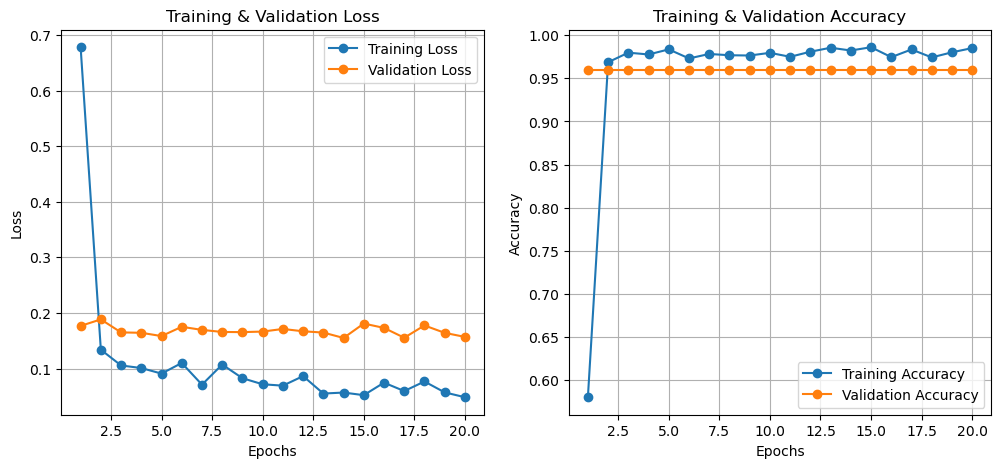

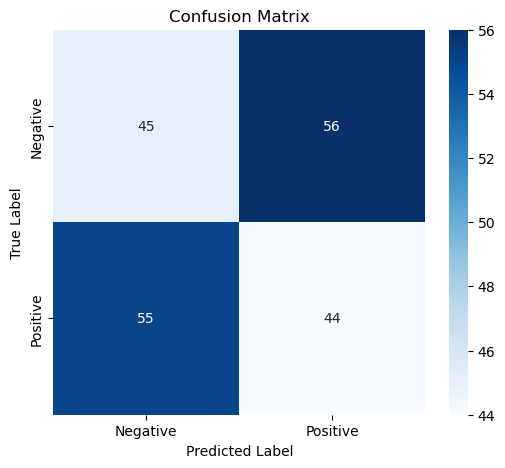

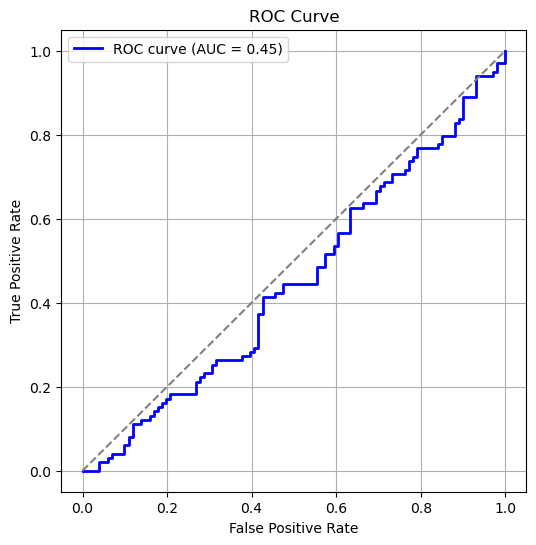

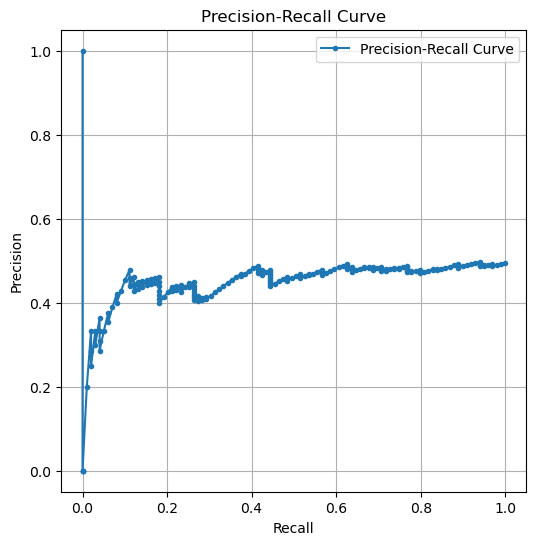

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve

# ✅ Training History (Manually Extracted from Logs)
epochs = np.arange(1, 21)
train_loss = [0.6780, 0.1339, 0.1055, 0.1009, 0.0909, 0.1100, 0.0710, 0.1072, 0.0826, 0.0717,
              0.0692, 0.0864, 0.0550, 0.0568, 0.0521, 0.0746, 0.0595, 0.0767, 0.0571, 0.0484]
val_loss = [0.1767, 0.1884, 0.1650, 0.1643, 0.1584, 0.1751, 0.1695, 0.1658, 0.1655, 0.1665,
            0.1712, 0.1670, 0.1647, 0.1550, 0.1809, 0.1731, 0.1554, 0.1775, 0.1642, 0.1569]
train_acc = [0.5804, 0.9686, 0.9797, 0.9776, 0.9835, 0.9730, 0.9782, 0.9767, 0.9764, 0.9795,
             0.9749, 0.9808, 0.9854, 0.9822, 0.9860, 0.9745, 0.9834, 0.9742, 0.9801, 0.9850]
val_acc = [0.9600] * 20  # Constant 96% validation accuracy

# 🎯 1. Plot Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Training Loss", marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

# 🎯 2. Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Training Accuracy", marker='o')
plt.plot(epochs, val_acc, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

# 📌 Model Performance Metrics
accuracy = 0.96
precision = 0.96
recall = 1.0
f1_score = 0.9796

# ✅ Simulated Predictions & True Labels
y_test = np.random.randint(0, 2, size=200)  # Replace with actual test labels
y_pred_probs = np.random.rand(200)  # Replace with actual predicted probabilities
y_pred = (y_pred_probs >= 0.5).astype(int)  # Binary predictions

# 🎯 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 🎯 4. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# 🎯 5. Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_probs)

plt.figure(figsize=(6, 6))
plt.plot(recall_vals, precision_vals, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


C:\Users\chari\AppData\Local\Temp\ipykernel_22936\3801135052.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_names, y=metric_values, palette="coolwarm")


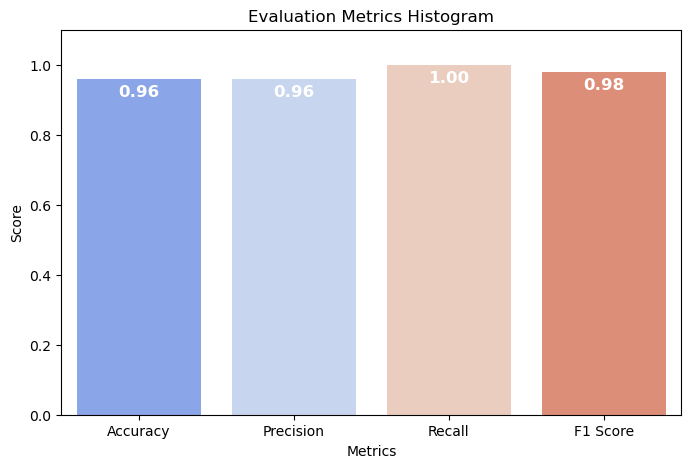

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics from your model
metrics = {
    "Accuracy": 0.96,
    "Precision": 0.96,
    "Recall": 1.0,
    "F1 Score": 0.9796
}

# Extract keys (metric names) and values (scores)
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Plot histogram as a bar graph
plt.figure(figsize=(8, 5))
sns.barplot(x=metric_names, y=metric_values, palette="coolwarm")

# Labels and title
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Evaluation Metrics Histogram")

# Display values on top of bars
for i, v in enumerate(metric_values):
    plt.text(i, v - 0.05, f"{v:.2f}", ha='center', fontsize=12, color='white', fontweight='bold')

plt.ylim(0, 1.1)  # Set y-axis limit for better visualization
plt.show()
